Tree with cutoff 0.2:
Training Error = 0.1754, Test Error = 0.1746
Validation Accuracy: 0.8246, Precision: 0.9008, Recall: 0.3022, F1-score: 0.4525
Test Accuracy: 0.8254, Precision: 0.8571, Recall: 0.3152, F1-score: 0.4609


Tree with cutoff 0.4:
Training Error = 0.1754, Test Error = 0.1746
Validation Accuracy: 0.8246, Precision: 0.9008, Recall: 0.3022, F1-score: 0.4525
Test Accuracy: 0.8254, Precision: 0.8571, Recall: 0.3152, F1-score: 0.4609


Tree with cutoff 0.6:
Training Error = 0.1754, Test Error = 0.1746
Validation Accuracy: 0.8246, Precision: 0.9008, Recall: 0.3022, F1-score: 0.4525
Test Accuracy: 0.8254, Precision: 0.8571, Recall: 0.3152, F1-score: 0.4609


Tree with cutoff 0.8:
Training Error = 0.2399, Test Error = 0.2368
Validation Accuracy: 0.7601, Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000
Test Accuracy: 0.7632, Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000




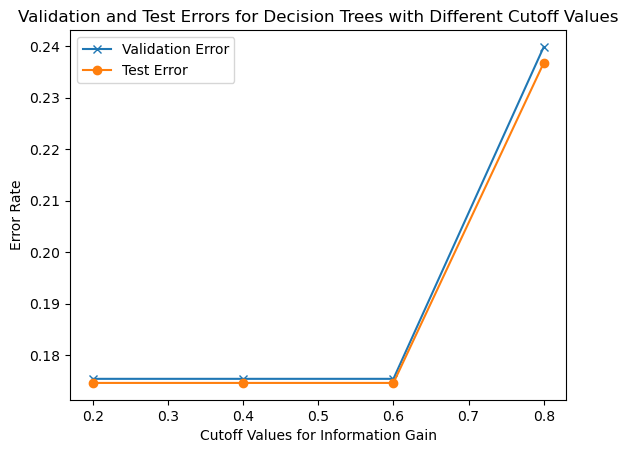

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data Loading
data = pd.read_csv('adult.csv')
data['income'] = data['income'].map({'<=50K': 0, '>50K': 1})
X = data.drop('income', axis=1)
y = data['income']

# # Check the distribution of the target variable
# print("Distribution of the target variable:")
# print(y.value_counts())

# Function to split data into training, validation, and test sets
def split_data(X, y, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2, seed=None):
    np.random.seed(seed)
    data_size = len(X)
    indices = np.arange(data_size)
    np.random.shuffle(indices)

    train_size = int(train_ratio * data_size)
    val_size = int(val_ratio * data_size)

    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]

    X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
    X_val, y_val = X.iloc[val_indices], y.iloc[val_indices]
    X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]

    return X_train, y_train, X_val, y_val, X_test, y_test

# C4.5 algorithm implementation
class DecisionNode:
    def __init__(self, feature=None, threshold=None, value=None, left=None, right=None):
        self.feature = feature
        self.threshold = threshold
        self.value = value
        self.left = left
        self.right = right

def calculate_entropy(labels):
    # Calculate the entropy of a set of labels
    unique_labels, counts = np.unique(labels, return_counts=True)
    probabilities = counts / len(labels)
    entropy = -np.sum(np.fromiter((p * np.log2(p) for p in probabilities), dtype=float))
    return entropy

def calculate_information_gain_ratio_continuous(data, labels, feature, threshold):
    # Calculate information gain ratio for continuous features
    total_entropy = calculate_entropy(labels)

    left_mask = data.iloc[:, feature].values <= threshold
    right_mask = ~left_mask

    left_entropy = calculate_entropy(labels[left_mask])
    right_entropy = calculate_entropy(labels[right_mask])

    information_gain = total_entropy - (len(labels[left_mask]) / len(labels) * left_entropy +
                                       len(labels[right_mask]) / len(labels) * right_entropy)

    intrinsic_value = -((len(labels[left_mask]) / len(labels)) * np.log2(len(labels[left_mask]) / len(labels))
                       + (len(labels[right_mask]) / len(labels)) * np.log2(len(labels[right_mask]) / len(labels)))

    # Avoid division by zero
    gain_ratio = information_gain / (intrinsic_value + 1e-10)

    return gain_ratio

def calculate_information_gain_ratio_discrete(data, labels, feature):
    # Calculate information gain ratio for discrete features
    total_entropy = calculate_entropy(labels)
    # print(f"discrete feature:{total_entropy}")
    unique_values = np.unique(data.iloc[:, feature].values)

    weighted_entropy = 0
    intrinsic_value = 0

    for value in unique_values:
        value_mask = data.iloc[:, feature] == value
        value_labels = labels[value_mask]
        value_entropy = calculate_entropy(value_labels)

        weighted_entropy += (len(value_labels) / len(labels)) * value_entropy
        intrinsic_value -= (len(value_labels) / len(labels)) * np.log2(len(value_labels) / len(labels))

    information_gain = total_entropy - weighted_entropy

    # Avoid division by zero
    gain_ratio = information_gain / (intrinsic_value + 1e-10)

    return gain_ratio

def find_best_split(data, labels, features, max_depth, cutoff):
    # Recursive function to find the best split for a node
    if len(set(labels)) == 1 or len(features) == 0 or max_depth == 0:
        # Base case: return None for leaf nodes
        return None

    best_feature = None
    best_threshold = None
    best_gain_ratio = -1

    # For each feature
    for feature in features:
        unique_values = np.unique(data.iloc[:, feature].values)

        if len(unique_values) > 1 and np.issubdtype(data.iloc[:, feature].dtype, np.number):
            # For continuous features, find the best threshold
            thresholds = (unique_values[:-1] + unique_values[1:]) / 2

            for threshold in thresholds:
                gain_ratio = calculate_information_gain_ratio_continuous(data, labels, feature, threshold)

                # print(f"Feature {feature}, Threshold {threshold}, Gain Ratio {gain_ratio}")
                
                if gain_ratio > best_gain_ratio:
                    best_feature = feature
                    best_threshold = threshold
                    best_gain_ratio = gain_ratio

        else:
            # For discrete features
            gain_ratio = calculate_information_gain_ratio_discrete(data, labels, feature)

            if gain_ratio > best_gain_ratio:
                best_feature = feature
                best_threshold = None
                best_gain_ratio = gain_ratio

    if best_gain_ratio == 0:
        # If no further split is beneficial, return None for leaf nodes
        return None
    # print(f"Feature {best_feature}, Threshold {best_threshold}")
    return best_feature, best_threshold

def build_decision_tree(data, labels, features, max_depth, cutoff):
    # Recursive function to build a decision tree
    if len(set(labels)) == 1 or len(features) == 0 or max_depth == 0 or calculate_entropy(labels) < cutoff:
        # print(f"Entropy: {calculate_entropy(labels)}")
        # print(f"Current Depth :{max_depth}")
        # Base case: create a leaf node with the majority class
        if len(labels) == 0:
            # Return a default value or handle this case accordingly
            return DecisionNode(value=0)
        return DecisionNode(value=np.argmax(np.bincount(labels)))

    best_feature, best_threshold = find_best_split(data, labels, features, max_depth, cutoff)

    if best_feature is None:
        # If no further split is beneficial, create a leaf node with the majority class
        if len(labels) == 0:
            # Return a default value or handle this case accordingly
            return DecisionNode(value=0)
        return DecisionNode(value=np.argmax(np.bincount(labels)))

    left_mask = data.iloc[:, best_feature] <= best_threshold
    right_mask = ~left_mask

    # Calculate class weights
    class_weights = len(labels) / (2 * np.bincount(labels) + 1e-10)

    # Recursively build left and right subtrees with adjusted class weights
    left_subtree = build_decision_tree(data.loc[left_mask], labels[left_mask], features, max_depth - 1, cutoff)
    right_subtree = build_decision_tree(data.loc[right_mask], labels[right_mask], features, max_depth - 1, cutoff)

    # Create a decision node for the best feature and threshold
    return DecisionNode(feature=best_feature, threshold=best_threshold, left=left_subtree, right=right_subtree)

def predict(tree, instance):
    # Traverse the tree to make a prediction for a single instance
    while tree.value is None:
        if np.issubdtype(X.dtypes[tree.feature], np.number):  # Numerical feature
            if instance[tree.feature] <= tree.threshold:
                tree = tree.left
            else:
                tree = tree.right
        else:  # Categorical feature
            if instance[tree.feature] == tree.threshold:
                tree = tree.left
            else:
                tree = tree.right
    return tree.value

def calculate_metrics(y_true, y_pred):
    true_positives = np.sum((y_true == 1) & (y_pred == 1))
    false_positives = np.sum((y_true == 0) & (y_pred == 1))
    false_negatives = np.sum((y_true == 1) & (y_pred == 0))
    true_negatives = np.sum((y_true == 0) & (y_pred == 0))

    accuracy = np.sum(y_true == y_pred) / len(y_true)

    precision = true_positives / (true_positives + false_positives + 1e-10)
    recall = true_positives / (true_positives + false_negatives + 1e-10)

    f1_score = 2 * (precision * recall) / (precision + recall + 1e-10)

    return accuracy, precision, recall, f1_score
    
# Set cutoff values
cutoff_values = [0.2, 0.4, 0.6, 0.8]

# Set maximum depth for recursive splitting
max_depth = 5

val_errors = []
validation_metrics = []
test_errors = []
test_metrics = []

# Train decision trees for different cutoff values
for cutoff in cutoff_values:
    X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, seed=42)
    tree = build_decision_tree(X_train, y_train, list(range(X_train.shape[1])), max_depth, cutoff)

    y_val_pred = np.array([predict(tree, instance) for instance in X_val.values])
    y_test_pred = np.array([predict(tree, instance) for instance in X_test.values])

    # Calculating training and test error
    training_error = np.sum(y_val_pred != y_val) / len(y_val)
    test_error = np.sum(y_test_pred != y_test) / len(y_test)

    val_errors.append(training_error)
    test_errors.append(test_error)
    
    print(f"Tree with cutoff {cutoff}:")
    print(f"Training Error = {training_error:.4f}, Test Error = {test_error:.4f}")
    
    # Calculate accuracy, F1, precision, and recall value
    validation_metric = calculate_metrics(y_val, y_val_pred)
    test_metric = calculate_metrics(y_test, y_test_pred)
    
    validation_metrics.append(validation_metric)
    test_metrics.append(test_metric)
    
    print(f"Validation Accuracy: {validation_metric[0]:.4f}, Precision: {validation_metric[1]:.4f}, Recall: {validation_metric[2]:.4f}, F1-score: {validation_metric[3]:.4f}")
    print(f"Test Accuracy: {test_metric[0]:.4f}, Precision: {test_metric[1]:.4f}, Recall: {test_metric[2]:.4f}, F1-score: {test_metric[3]:.4f}")
    print("\n")

# Plotting the training and test errors
plt.plot(cutoff_values, val_errors, label='Validation Error', marker='x')
plt.plot(cutoff_values, test_errors, label='Test Error', marker='o')
plt.xlabel('Cutoff Values for Information Gain')
plt.ylabel('Error Rate')
plt.title('Validation and Test Errors for Decision Trees with Different Cutoff Values')
plt.legend()
plt.show()